In [74]:
import json
import pandas as pd
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import plotly.express as px

In [75]:
DATA_FILES = [f for f in Path('data').glob('*.json')]

In [76]:
# Load data
author_affiliations = {}
all_papers = []
for filename in DATA_FILES:
    venue = filename.stem
    year = int(venue[-2:]) + 2000
    with open(filename) as f:
        papers = json.load(f)
    for paper in papers:
        authors = []
        affiliations = []
        for author in paper['authors']:
            # TODO check if any author changed affiliations. Yep, that happens...
            name = author['name']
            affiliation = author['affiliation']
            author_affiliations[name] = affiliation
            authors.append(name)
            affiliations.append(affiliation)
        paper['authors'] = authors
        paper['affiliations'] = affiliations
        paper['venue'] = venue
        paper['year'] = year
        all_papers.append(paper)
papers = pd.DataFrame(all_papers)
papers.head()

title  \
0              The computing at school working group   
1                           The fastest man on earth   
2    Kinetic: a learning environment within business   
3  An informatics perspective on computational th...   
4  Computational thinking in educational activiti...   

                                             link  \
0  https://dl.acm.org/doi/10.1145/2462476.2483794   
1  https://dl.acm.org/doi/10.1145/2462476.2483795   
2  https://dl.acm.org/doi/10.1145/2462476.2483796   
3  https://dl.acm.org/doi/10.1145/2462476.2483797   
4  https://dl.acm.org/doi/10.1145/2462476.2466518   

                                            abstract  \
0  The Computing at School (CAS) Working Group ai...   
1  Wing Commander Andy Green is a Royal Air Force...   
2  Kinetic Solutions was born from the vision of ...   
3  In this paper, we examine computational thinki...   
4  Computational thinking is gaining recognition ...   

                                             authors  \
0                               [Simon Peyton Jones]   
1                                       [Andy Green]   
2                                  [Chris Wildsmith]   
3  [Maureen Doyle, Zachary Hart, Rudy Garns, Jame...   
4  [Lindsey Ann Gouws, Peter Wentworth, Karen Bra...   

                                                tags  \
0                            [teaching cs in school]   
1                          [educational communities]   
2                                [lifelong learning]   
3              [informatics, computational thinking]   
4  [computer science education, evaluation framew...   

                                        affiliations     venue  year  
0  [Microsoft Research - Cambridge, Cambridge, Un...  ITiCSE13  2013  
1          [Royal Air Force, London, United Kingdom]  ITiCSE13  2013  
2     [Kinetic Solutions, Cranfield, United Kingdom]  ITiCSE13  2013  
3  [Northern Kentucky University, Highland Height...  ITiCSE13  2013  
4  [Rhodes University, Grahamstown, South Africa,...  ITiCSE13  2013

In [77]:
# Define functions
def find_keywords(keywords):
    def find(row):
        search_str = row.title.lower() + row.abstract.lower() + ''.join(t.lower() for t in row.tags)
        for word in keywords:
            if word in search_str:
                return 1
        return 0
    return find


def papers_with_keywords_percent(papers, keywords):
    found = papers.apply(find_keywords(keywords), axis=1).sum()
    return 100 * found / len(papers)


def sort_by_occurrence(values, decreasing=True):
    c = Counter(values)
    return sorted(((count, v) for v, count in c.items()), reverse=decreasing)

# Counting some keywords

In [78]:
search_keywords = [
    ['automatic', 'automated'],
    ['project'],
    ['assess'],
    ['peer'],
    ['review'],
    ['code'],
    ['test'],
    ['active learning'],
    ['game'],
]
years = sorted(papers.year.unique())
for keywords in search_keywords:
    print(f'KEYWORDS: {", ".join(keywords)}')
    for year in years:
        papers_by_year = papers[papers.year == year]
        print(f'{year}: {papers_with_keywords_percent(papers_by_year, keywords):.2f}% of the papers include the keywords')
    print()

KEYWORDS: automatic, automated
2010: 2.82% of the papers include the keywords
2011: 3.97% of the papers include the keywords
2012: 4.76% of the papers include the keywords
2013: 5.60% of the papers include the keywords
2014: 5.41% of the papers include the keywords
2015: 7.07% of the papers include the keywords
2016: 6.93% of the papers include the keywords
2017: 8.12% of the papers include the keywords
2018: 5.22% of the papers include the keywords
2019: 5.01% of the papers include the keywords
2020: 6.05% of the papers include the keywords

KEYWORDS: project
2010: 17.34% of the papers include the keywords
2011: 18.65% of the papers include the keywords
2012: 17.46% of the papers include the keywords
2013: 19.05% of the papers include the keywords
2014: 25.64% of the papers include the keywords
2015: 23.30% of the papers include the keywords
2016: 19.94% of the papers include the keywords
2017: 24.35% of the papers include the keywords
2018: 25.66% of the papers include the keywords
2

# Common Author Tags

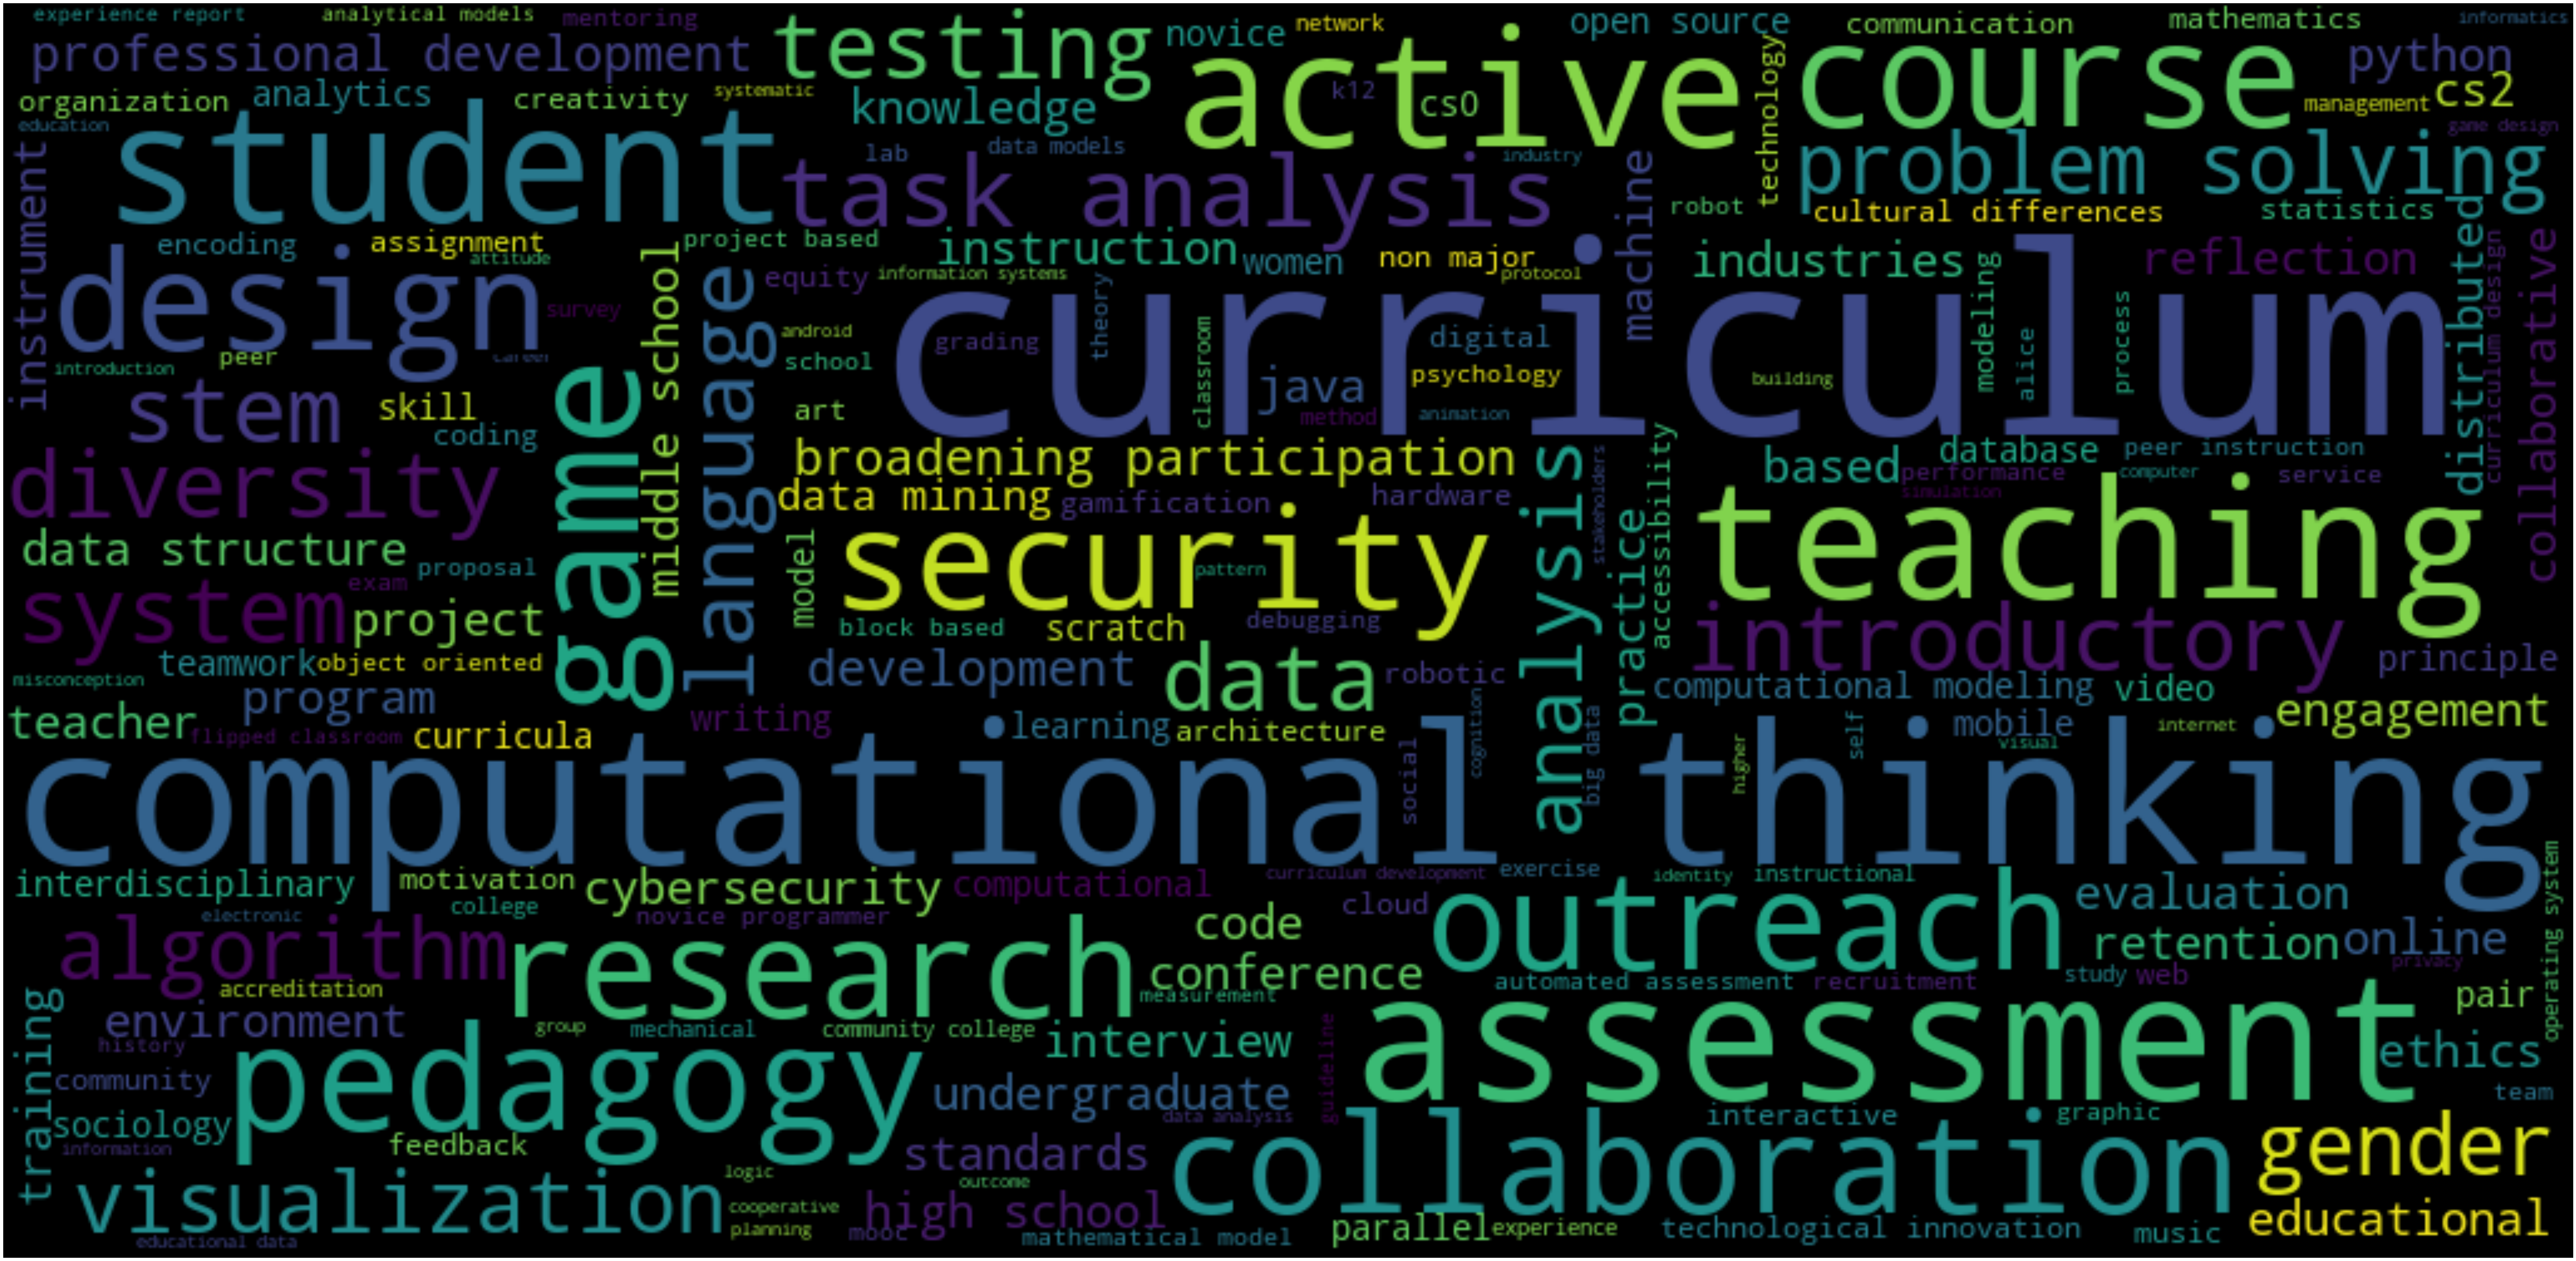

In [79]:
ignore = ['programming', 'education', 'learning', 'computer', 'science', 'computing', 'student', 'cs1', 'tool', 'cs', 'engineering', 'software', 'tools', 'profession']
all_tags = (w.lower().strip() for t in papers.tags.sum() for w in t.split())
all_tags = ' '.join(w for w in all_tags if w not in ignore)
wordcloud = WordCloud(width=1024, height=500).generate(all_tags)
fig, ax = plt.subplots(figsize=(100, 50))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
pass

In [80]:
all_tags = [t.lower() for t in papers.tags.sum()]
for count, tag in sort_by_occurrence(all_tags):
    if count > 10:
        print(f'{tag} ({count} publications)')

education (502 publications)
computer science education (395 publications)
cs1 (298 publications)
computational thinking (231 publications)
tools (212 publications)
programming (188 publications)
active learning (164 publications)
computer science (163 publications)
assessment (145 publications)
curriculum (128 publications)
task analysis (119 publications)
pedagogy (117 publications)
engineering education (106 publications)
engineering profession (105 publications)
collaboration (105 publications)
programming profession (104 publications)
engineering students (100 publications)
software engineering (99 publications)
k-12 (99 publications)
stem (93 publications)
visualization (92 publications)
software (88 publications)
computing education (86 publications)
diversity (85 publications)
interviews (82 publications)
outreach (80 publications)
k-12 education (76 publications)
games (76 publications)
reflection (73 publications)
introductory programming (71 publications)
professional develo

In [81]:
def filter_tags_by_year(row):
    tags = row.tags
    year = int(row.venue[-2:]) + 2000
    return [{'year': year, 'tag': tag.lower()} for tag in tags]

tags_by_year = pd.DataFrame(papers.apply(filter_tags_by_year, axis=1).sum())
tag_counts = tags_by_year.groupby('tag').count()
popular_tags = list(tag for tag in tag_counts[tag_counts.year > 20].index if tag)
popular_tags_by_year = tags_by_year[tags_by_year.tag.isin(popular_tags)]
tby = popular_tags_by_year.groupby(['tag', 'year']).year.count().unstack().fillna(0)
tby[tby[2018] < tby[2020]]

year                      2010  2011  2012  2013  2014  2015  2016  2017  \
tag                                                                        
accessibility              0.0   1.0   0.0   1.0   2.0   3.0   2.0   6.0   
android                    0.0   3.0   4.0   9.0   3.0   4.0   1.0   0.0   
assessment                 8.0   5.0   8.0  14.0   7.0  10.0  11.0  15.0   
automated grading          0.0   1.0   2.0   1.0   3.0   3.0   1.0   3.0   
block-based programming    0.0   0.0   0.0   0.0   0.0   1.0   1.0   3.0   
broadening participation   3.0   1.0   0.0   4.0   5.0  12.0   8.0   3.0   
computational thinking    11.0  12.0  11.0  25.0  17.0  13.0  13.0  25.0   
computing education        0.0   3.0   2.0   5.0   7.0   3.0   3.0   4.0   
cs2                        4.0   2.0   0.0  10.0   6.0   7.0   8.0   5.0   
curriculum                13.0   3.0  10.0  13.0  11.0  14.0   8.0  10.0   
cybersecurity education    0.0   0.0   0.0   0.0   0.0   0.0   2.0   3.0   
debugging                  1.0   0.0   0.0   1.0   1.0   1.0   4.0   1.0   
diversity                  4.0   4.0   3.0   6.0   6.0   5.0   9.0  10.0   
educational data mining    0.0   0.0   0.0   1.0   1.0   0.0   5.0   8.0   
equity                     0.0   0.0   0.0   1.0   1.0   0.0   2.0   2.0   
experience report          1.0   2.0   4.0   2.0   4.0   2.0   2.0   1.0   
feedback                   1.0   2.0   1.0   2.0   2.0   0.0   4.0   3.0   
flipped classroom          0.0   0.0   0.0   3.0   2.0   7.0   3.0   1.0   
gamification               0.0   0.0   0.0   2.0   6.0   2.0   5.0   3.0   
gender                     5.0   2.0   3.0   4.0   5.0   2.0   1.0  13.0   
k-12                       4.0   3.0   5.0   7.0   7.0   9.0  10.0  11.0   
learning                   3.0   1.0   0.0   4.0   2.0   1.0   2.0   3.0   
non-majors                 2.0   3.0   3.0   5.0   3.0   6.0   1.0   7.0   
novice programmers         1.0   3.0   0.0   1.0   2.0   2.0   3.0   1.0   
pogil                      0.0   0.0   2.0   2.0   3.0   3.0   4.0   7.0   
problem solving            1.0   0.0   1.0   1.0   3.0   3.0   1.0   4.0   
robotics                   4.0   4.0   0.0   7.0   2.0   2.0   1.0   3.0   
scratch                    6.0   3.0   6.0   5.0   3.0   3.0   4.0   4.0   
student engagement         0.0   1.0   0.0   0.0   2.0   5.0   2.0   0.0   
teaching                   3.0   1.0   1.0   1.0   3.0   4.0   4.0   1.0   

year                      2018  2019  2020  
tag                                         
accessibility              6.0   9.0  10.0  
android                    1.0   2.0   3.0  
assessment                18.0  26.0  23.0  
automated grading          2.0   2.0   3.0  
block-based programming    3.0   5.0   9.0  
broadening participation   7.0  14.0  13.0  
computational thinking    29.0  38.0  37.0  
computing education       16.0  20.0  23.0  
cs2                        7.0   8.0   8.0  
curriculum                10.0  18.0  18.0  
cybersecurity education    8.0   9.0   9.0  
debugging                  7.0   7.0   8.0  
diversity                 13.0  11.0  14.0  
educational data mining    2.0   2.0   7.0  
equity                     8.0  12.0  14.0  
experience report          2.0   1.0   5.0  
feedback                   2.0   4.0   5.0  
flipped classroom          4.0   1.0   5.0  
gamification               3.0  11.0   6.0  
gender                    10.0  12.0  12.0  
k-12                      10.0  14.0  19.0  
learning                   1.0   2.0   3.0  
non-majors                 2.0   3.0   4.0  
novice programmers         5.0   7.0   7.0  
pogil                      3.0   3.0   4.0  
problem solving            1.0   8.0   4.0  
robotics                   3.0   4.0   4.0  
scratch                    6.0   4.0   7.0  
student engagement         5.0   8.0   7.0  
teaching                   4.0   6.0   6.0

In [82]:
groups = {
    'gender and diversity': ['women in computing', 'broadening participation in computing', 'gender', 'gender and diversity', 'diversity', 'gender issues', 'women', 'cs for all'],
    'accessibility': ['accessibility', 'disability'],
    'automated grading': ['automated grading', 'grading', 'unit testing', 'autograding', 'automated assessment'],
    'gamification': ['games', 'gamification'],
    'soft skills': ['soft skills', 'communication', 'teamwork'],
    'online learning': ['online learning', 'online education', 'mooc'],
    'peer instruction': ['peer review', 'cooperative learning', 'peer instruction', 'collaborative learning', 'pair programming'],
    'open source': ['open source'],
    'feedback': ['feedback'],
    'interdisciplinary': ['interdisciplinary'],
    'project-based learning': ['project-based learning'],
    'ethics': ['ethics'],
    'active learning': ['active learning'],
}

tby = tags_by_year
for group in groups:
    for tag in groups[group]:
        tby.loc[tby.tag == tag,'tag'] = group

tby = tby.groupby(['tag', 'year']).year.count()
tby = tby.rename('total').reset_index()
selected_tby = tby[tby.tag.isin(groups.keys())]
fig = px.line(selected_tby, x='year', y='total', color='tag', title='')
fig.show()

# Authors

In [83]:
for count, name in sort_by_occurrence(papers.authors.sum()):
    if count > 5:
        print(f'{name} ({count} publications)') 

Leo Porter (45 publications)
Tiffany Barnes (42 publications)
Daniel D. Garcia (40 publications)
Daniel Zingaro (33 publications)
Mark Guzdial (32 publications)
Kristy Elizabeth Boyer (32 publications)
Stephen H. Edwards (31 publications)
Clifford A. Shaffer (30 publications)
Joel C. Adams (27 publications)
Jeff Gray (27 publications)
Diana Franklin (26 publications)
Andrew Petersen (26 publications)
Jens Mache (24 publications)
Paul Denny (23 publications)
Michelle Craig (23 publications)
Helen H. Hu (23 publications)
Elizabeth Shoop (23 publications)
Colleen M. Lewis (23 publications)
Adrienne Decker (23 publications)
Monica M. McGill (22 publications)
Brett A. Becker (22 publications)
Mehran Sahami (21 publications)
Katrina Falkner (21 publications)
Christina Gardner-McCune (21 publications)
Siddharth Kaza (20 publications)
Mark Sherriff (20 publications)
Cynthia Taylor (20 publications)
Chris Mayfield (20 publications)
Blair Taylor (20 publications)
Barbara Ericson (20 publications